In [1]:
!pip install ultralytics > /dev/null

In [2]:
import cv2
import pandas as pd
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import math
import os
from collections import defaultdict, Counter
from scipy.spatial import distance
import glob
import torch
import pydantic

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install moviepy > /dev/null

In [4]:
from moviepy.editor import VideoFileClip, AudioFileClip

  if event.key is 'enter':



In [5]:
!pip install pyannote.audio > /dev/null
!pip freeze | grep -i pyannote >/dev/null

In [6]:
# hugging face の token が必要
from pyannote.audio import Pipeline
from google.colab import userdata
import torch

pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=userdata.get('HF_TOKEN')
)

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [7]:
!pip install ffmpeg-python > /dev/null

## 0: loadmodel

In [8]:
## 良いほうのモデル
model = YOLO("yolov8x-pose.pt")

100%|██████████| 133M/133M [00:04<00:00, 33.9MB/s]


In [9]:
# keypointの位置毎の名称定義
KEYPOINTS_NAMES = [
    "nose",  # 0
    "eyeL",  # 1
    "eyeR",  # 2
    "earL",  # 3
    "earR",  # 4
    "shoulderL",  # 5
    "shoulderR",  # 6
    "elbowL",  # 7
    "elbowR",  # 8
    "wristL",  # 9
    "wristR",  # 10
    "hipL",  # 11
    "hipR",  # 12
    "kneeL",  # 13
    "kneeR",  # 14
    "ankleL",  # 15
    "ankleR",  # 16
]

In [10]:
COLOR_MAP = {"blue": (255, 0, 0),
             "red": (0, 0, 255),
             "green": (0, 255, 0),
             "orange": (0, 165, 255),
             "black": (0, 0, 0),
             "white": (255, 255, 255)
}

In [11]:
!pwd

/content


In [12]:
!unzip /content/ideal_poses_2.zip > /dev/null

In [13]:
from dataclasses import dataclass, fields
from typing import Optional, Tuple

In [14]:
@dataclass
class RelativeXY:
    """
    PersonKeypointsからnose を起点とした XY 座標
    """
    nose: Tuple[int, int] = (0, 0) # 0
    eyeL: Optional[Tuple[int, int]] = None# 1
    eyeR: Optional[Tuple[int, int]] = None  # 2
    earL: Optional[Tuple[int, int]] = None  # 3
    earR: Optional[Tuple[int, int]] = None  # 4
    shoulderL: Optional[Tuple[int, int]] = None  # 5
    shoulderR: Optional[Tuple[int, int]] = None  # 6
    elbowL: Optional[Tuple[int, int]] = None  # 7
    elbowR: Optional[Tuple[int, int]] = None  # 8
    wristL: Optional[Tuple[int, int]] = None  # 9
    wristR: Optional[Tuple[int, int]] = None  # 10
    hipL: Optional[Tuple[int, int]] = None  # 11
    hipR: Optional[Tuple[int, int]] = None  # 12
    kneeL: Optional[Tuple[int, int]] = None  # 13
    kneeR: Optional[Tuple[int, int]] = None  # 14
    ankleL: Optional[Tuple[int, int]] = None  # 15
    ankleR: Optional[Tuple[int, int]] = None  # 16

    @classmethod
    def from_keypoints(cls, keypoints: "PersonKeypoints") -> "RelativeXY":
      norm_xydict = {}
      scale_factor = 1.0
      if keypoints.is_all_none():
        return cls()

      if (keypoints.nose is not None) & (keypoints.hipL is not None):
        scale_factor = np.linalg.norm(np.array(keypoints.nose) - np.array(keypoints.hipL))
      for field in keypoints.__dataclass_fields__:
          point = getattr(keypoints, field)
          if point is None:
            norm_xydict[field] = [0, 0]
          else:
            norm_xydict[field] = [point[0] / scale_factor, point[1] / scale_factor]

      relative_xydict = {"nose": [0,0]}
      if ("nose" not in norm_xydict.keys() or norm_xydict["nose"] == None):
        return RelativeXY(**relative_xydict)
      for key in norm_xydict.keys():
        if key == "nose":
          continue
        point = getattr(keypoints, key)
        if point is None:
          point = [0, 0]
        x = keypoints.nose[0] - point[0]
        y = keypoints.nose[1] - point[1]
        relative_xydict[key] = [x, y]

      return cls(**relative_xydict)

    @classmethod
    def from_mean_relativeXYs(cls, relativeXYs: list["RelativeXY"]) -> "RelativeXY":
      sums = defaultdict(lambda: [0.0, 0.0, 0])  # part_name -> [sum_x, sum_y, count]
      for relativeXY in relativeXYs:
          for field in relativeXY.__dataclass_fields__:
              point = getattr(relativeXY, field)
              if point is not None:
                  sums[field][0] += point[0]
                  sums[field][1] += point[1]
                  sums[field][2] += 1

      avg_data = {}
      for part, (sum_x, sum_y, cnt) in sums.items():
          if cnt > 0:
              avg_data[part] = (sum_x / cnt, sum_y / cnt)
          else:
              avg_data[part] = None

      return cls(**avg_data)

    def flatten_relative_xys(self) -> np.ndarray:
      tmp_data = [
          [val[0], val[1]] if val is not None else [0, 0]
          for val in [getattr(self, keypoint) for keypoint in self.__dataclass_fields__]
      ]
      flatten_np = np.array(tmp_data).flatten()
      return flatten_np

In [15]:
@dataclass
class IdealPose:
  """
  理想ポーズ
  """
  pose_name: str
  relative_xy: RelativeXY
  cov_i: np.ndarray

  @classmethod
  def from_xys(cls, pose_name: str, relative_xy_list: list["RelativeXY"]) -> "IdealPose":
    ideal_relative_xy: RelativeXY = RelativeXY.from_mean_relativeXYs(relative_xy_list)
    cov_i: np.ndarray = cls._calculate_cov_from_posedict(relative_xy_list)
    return cls(pose_name = pose_name, relative_xy = ideal_relative_xy, cov_i = cov_i)

  @classmethod
  def _calculate_cov_from_posedict(cls, ideal_relative_xy_list: list[RelativeXY]) -> np.ndarray:
    """
    pose_xydict を展開し、ベクトル化して共分散行列を計算する
    """
    vectors = []
    # 存在しない座標はひとまずゼロ埋め
    for relative_xy in ideal_relative_xy_list:
      flatten_np: np.ndarray = relative_xy.flatten_relative_xys()
      vectors.append(flatten_np)


    X = np.array(vectors)
    # 分散共分散行列を計算
    cov = np.cov(X.T)
    # 分散共分散行列の逆行列を計算
    cov_i = np.linalg.pinv(cov)

    return cov_i

In [16]:
@dataclass
class PersonKeypoints:
    """
    result から取得した各座標
    """
    nose: Optional[Tuple[float, float]] = None
    eyeL: Optional[Tuple[float, float]] = None
    eyeR: Optional[Tuple[float, float]] = None
    earL: Optional[Tuple[float, float]] = None
    earR: Optional[Tuple[float, float]] = None
    shoulderL: Optional[Tuple[float, float]] = None
    shoulderR: Optional[Tuple[float, float]] = None
    elbowL: Optional[Tuple[float, float]] = None
    elbowR: Optional[Tuple[float, float]] = None
    wristL: Optional[Tuple[float, float]] = None
    wristR: Optional[Tuple[float, float]] = None
    hipL: Optional[Tuple[float, float]] = None
    hipR: Optional[Tuple[float, float]] = None
    kneeL: Optional[Tuple[float, float]] = None
    kneeR: Optional[Tuple[float, float]] = None
    ankleL: Optional[Tuple[float, float]] = None
    ankleR: Optional[Tuple[float, float]] = None

    def is_all_none(self) -> bool:
      return all(getattr(self, f.name) is None for f in fields(self))

    @classmethod
    def from_yolo_result(cls, yolo_result) -> "PersonKeypoints":
      return cls.from_yolo_keypoints(yolo_result.keypoints)

    @classmethod
    def from_yolo_keypoints(cls, keypoints) -> "PersonKeypoints":
      data = {} # 人ごとの座標が入っている
      for conf, xy in zip(keypoints.conf, keypoints.xy):

        for index, keypoint in enumerate(zip(xy, conf)):
            score = keypoint[1]
            # 鼻を基準とするため、鼻のスコアが 0.5 以下の場合とばす
            if (index == 0) & (score < 0.5):
              # xys.append(xydict)
              break

            x = int(keypoint[0][0])
            y = int(keypoint[0][1])
            # 何も入っていない場合飛ばす
            if x == 0 & y == 0:
              continue
            if torch.cuda.is_available():
              data[KEYPOINTS_NAMES[index]] = [x, y, score.item()]
            else:
              data[KEYPOINTS_NAMES[index]] = [x, y, score]
        return cls(**data)

In [17]:
## 理想の姿勢を取得（おそらくここはやり方を変える
## 何かしらよいポーズを 2, 3用意し、それとの類似度あるいは分類問題にする）
def get_relative_xys(results) -> list[RelativeXY]:
  """
  YOLO解析結果から、鼻との相対位置のリストを取得
  そのキャプチャに存在する人のデータがリスト形式になって返却される
  """
  relative_xy_list = []
  for result in results:
    person_keypoints = PersonKeypoints.from_yolo_result(result)

    if person_keypoints.is_all_none():
      continue
    relative_xy = RelativeXY.from_keypoints(person_keypoints)

    relative_xy_list.append(relative_xy)
  return relative_xy_list

### 理想ポーズの取得

In [18]:
import glob
import cv2
poses = ["look_forward",
         "writing_note"]

ideal_pose_list = []
for pose in poses:
  ideal_relative_xy_list: list[RelativeXY] = []
  files = glob.glob(f"/content/ideal_poses_2/{pose}/*")

  for file in files:
    capture = cv2.imread(file)
    results = model(capture, verbose=False)
    # 描画された画像を取得（NumPy配列）
    result_img = results[0].plot()

    # 画像の中に複数人いる場合があるため、リスト形式
    tmp_relative_xy_list: list[RelativeXY] = get_relative_xys(results)
    ideal_relative_xy_list += tmp_relative_xy_list

  ideal_pose = IdealPose.from_xys(pose_name = pose, relative_xy_list=ideal_relative_xy_list)
  ideal_pose_list.append(ideal_pose)

In [19]:
@dataclass
class VideoInfo:
  cap: cv2.VideoCapture
  fps: int
  width: int
  height: int
  fourcc: int
  video_path: str

  @classmethod
  def load(cls, video_path: str) -> "VideoInfo":
      cap = cv2.VideoCapture(video_path)
      fps = int(cap.get(cv2.CAP_PROP_FPS))
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      fourcc = cv2.VideoWriter_fourcc(*"mp4v")
      return cls(cap, fps, width, height, fourcc, video_path)

@dataclass
class DetectXY:
  min: np.ndarray
  max: np.ndarray

@dataclass
class Settings:
  video_info: VideoInfo
  detect_area: Optional[DetectXY] = None
  mask_area: Optional[DetectXY] = None

  # ポーズ類似度の threshold、これを下回るとスコアを赤色表示かつ、どのポーズにも属していないとみなす
  posing_score_threhold: float = 0.7

  # ユーザの基準位置をとる秒数
  id_fetch_duration_sec: int = 5
  # IDを検出するインターバル
  id_fetch_interval: float = 0.5

  # スコア検出のwindow size秒数
  window_size_sec: int = 5


In [20]:
@dataclass
class TrackedPerson:
  id: int
  center_x: int
  center_y: int
  current_score: float = None
  pose: str = None

  def is_mask_area(self, mask_xy: DetectXY) -> bool:
    return (mask_xy.min[0] <= self.center_x <= mask_xy.max[0] and
            mask_xy.min[1] <= self.center_y <= mask_xy.max[1])

In [114]:
def get_user_position(frame, results, detect_xy: DetectXY, tracked_people: dict[int, TrackedPerson], threshold_dist: int = 80) -> dict[int, TrackedPerson]:
    """
    user position から id を採番する
    基準位置はユーザの矩形の中心点を取る
    Arg:
      frame: フレーム画像
      results: YOLO での解析結果
      detect_xy(dict): 検出対象位置、パーツを持つ dict
      tracked_people_xys(dict): ユーザの現在の基準位置。描画矩形の中心位置を取得している。 {0: [x, y], 1: [x, y], ...}
      threshold_dist(int): ユーザの中心位置のずれ。大きければ大きいほど違う人物を同じ人物としてしまう可能性があがる。
    Return:
      tracked_people_xys(dict): {0: [x, y], 1: [x, y], ...}
    """

    detection_people_xys = []
    for result in results:
      keypoints = result.keypoints.xy  # (人数, 関節数, 2)
      for i, box in enumerate(result.boxes.xyxy):
        kpts = keypoints[i].cpu().numpy()

        # 関節が5点以上検出されているかどうかチェック
        valid = (~np.isnan(kpts).any(axis=1) & (kpts[:, 0] > 0) & (kpts[:, 1] > 0)).sum()
        if valid < 5:
            continue  # 検出点が少ないならスキップ

        x1, y1, x2, y2 = map(int, box[:4])
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # 中心座標
        # 検出対象位置に cx, cy が存在しない場合はやめる
        if not (detect_xy.min[0] <= cx \
                and cx <= detect_xy.max[0] \
                and detect_xy.min[1] <= cy \
                and cy <= detect_xy.max[1]
        ):
          continue
        detection_people_xys.append([cx, cy])

    for cx, cy in detection_people_xys:
      # すでに登録している場合、場所を少し補正する
      matched_id = None
      for pid, tracked_person in tracked_people.items():
        if np.linalg.norm(np.array([cx, cy]) - np.array([tracked_person.center_x, tracked_person.center_y])) < threshold_dist:
            matched_id = pid
            new_cx, new_cy = (cx + tracked_person.center_x) // 2, (cy + tracked_person.center_y) // 2  # 中心座標
            tracked_people[pid].center_x = new_cx
            tracked_people[pid].center_y = new_cy
            break

      # 新規登録
      if matched_id is None:
        next_id = len(tracked_people.keys()) +1
        tracked_person = TrackedPerson(id=next_id, center_x=cx, center_y=cy)
        tracked_people[next_id] = tracked_person

    return tracked_people

In [123]:
#### utils 行
def show_detect_persons(frame, filtered_people_xys: dict[int, TrackedPerson]) -> None:
  print("もし抽出箇所が微妙な場合 CTRL + C を 2回押して強制終了")
  for id, tracked_person in filtered_people_xys.items():
    font_color = COLOR_MAP["red"]
    cv2.putText(frame, f"{id}",
      (tracked_person.center_x,tracked_person.center_y),
          cv2.FONT_HERSHEY_SIMPLEX, 1, font_color, 2, cv2.LINE_AA)
  scale = 0.5
  resized_img = cv2.resize(frame, None, fx=scale, fy=scale)
  cv2_imshow(resized_img)

def get_avg_dict(target_list):
  # 各キーごとの合計値とカウントを保持する辞書
  sum_dict = defaultdict(float)
  count_dict = defaultdict(int)

  # 合計値とカウントを計算
  for score_map in target_list:
    for key, value in score_map.items():
        sum_dict[key] += value
        count_dict[key] += 1

  # 平均値を計算
  avg_dict = {key: sum_dict[key] / count_dict[key] for key in sum_dict}
  return avg_dict

In [124]:
def find_nearest_id(tracked_people_xys: dict[int, TrackedPerson], x:int , y:int , threshold: int):
    nearest_id = None
    min_distance = float('inf')

    for id, tracked_person in tracked_people_xys.items():
        distance = math.sqrt((tracked_person.center_x - x) ** 2 + (tracked_person.center_y - y) ** 2)
        if distance <= threshold and distance < min_distance:
            min_distance = distance
            nearest_id = id

    return nearest_id

In [125]:
def get_person_xydict(result, tracked_people_xys: dict[int, TrackedPerson]) -> defaultdict:
  # result から中心点を取得する
  """person_id ごとの骨格点を取る
  """
  person_xydict = defaultdict(dict)
  # 矩形のxy, パーツ別confidence, パーツ位置xy
  for boxes_xy, keypoints in zip(result.boxes.xyxy, result.keypoints):
  # for boxes_xy, conf, xy in zip(result.boxes.xyxy, result.keypoints.conf, result.keypoints.xy):
    # まず id を取得
    x1, y1, x2, y2 = map(int, boxes_xy[:4])
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # 中心座標
    # 最も近い id を取り出し、なければ skip
    person_id = find_nearest_id(tracked_people_xys, cx, cy, threshold=100)
    if person_id is None:
      continue

    person_keypoints = PersonKeypoints.from_yolo_keypoints(keypoints)
    person_xydict[person_id] = person_keypoints
  return person_xydict

In [134]:
class FrameData:
    def __init__(self, frame_id, score_map, pose_map):
        self.frame_id = frame_id
        self.score_map = score_map # {person_id: {pose_type: 0.2, ..}
        self.pose_map = pose_map # {person_id: "pose1", ...}


class ScoreCollector:
    def __init__(self, avg_interval_fps):
        self.data = []
        self.avg_interval_fps = avg_interval_fps
        self.window_sec = 5 # 全体平均スコアを取るインターバルsec

        # 個人のinterval単位の平均
        self.interval_personal_score_list = [] # intervalごとの person 単位の平均スコアを保持
        self.interval_personal_pose_list = []

        # 全体の平均スコア
        self.interval_total_score_list = []
        self.interval_total_pose_list = []


    def add(self, frame_id, score_map, pose_map):
        self.data.append(FrameData(frame_id, score_map, pose_map))

        if frame_id % self.avg_interval_fps == 0:
          # interval ごとの平均値
          self.interval_personal_score_list.append(self._get_avg_score())
          # intervalごとのidごとの代表ポーズ
          self.interval_personal_pose_list.append(self._get_avg_pose())

    def calc_window_score(self, video_name: str):
      for i in range(0, len(self.interval_personal_score_list), self.window_sec):
        start_index = i
        if i + self.window_sec > len(self.interval_personal_score_list):
          end_index = len(self.interval_personal_score_list)
        else:
          end_index = i + self.window_sec

        avg_score_dict = get_avg_dict(self.interval_personal_score_list[start_index:end_index])

        # 平均を取る
        total_score = np.array(list(avg_score_dict.values())).mean()

        # 集中してる人数 / 全体の人数
        # total_score = calc_total_concenterate(avg_score_dict, threshold = threshold)

        # for csv
        avg_score_dict["total"] = total_score
        self.interval_total_score_list.append(avg_score_dict)
      if video_name:
        video_file_name = os.path.splitext(os.path.basename(video_path))[0]
        output_csv_path = f"/content/{video_name}_by{self.window_sec}_video_score_list.csv"
        pd.DataFrame(self.interval_total_score_list).to_csv(output_csv_path, index=False)
        print("csvの保存が完了しました。")


    def _get_avg_score(self) -> dict:
      """
      target_list(list[FrameData]): [{person_id: {pose_type: 0.2, ..}...}, {},...]
      """
      # 各キーごとの合計値とカウントを保持する辞書
      sum_dict = defaultdict(float)
      count_dict = defaultdict(int)

      # 合計値とカウントを計算
      for framedata in self.data[-self.avg_interval_fps:]:
        score_map = framedata.score_map
        for key, value in score_map.items():
            sum_dict[key] += value
            count_dict[key] += 1

      # 平均値を計算
      avg_dict = {key: sum_dict[key] / count_dict[key] for key in sum_dict}
      return avg_dict

    def _get_avg_pose(self):
      """各personが期間内に属している時間の長いposeを返却する
      target_list(list): [{person_id: "pose1", ...}, {},...]
      """
      # person ごとのポーズカウント
      counts = defaultdict(Counter) # {"person_id": {"pose1": 5, ...}}
      for framedata in self.data[-self.avg_interval_fps:]:
        pose_map = framedata.pose_map
        for person_id, pose in pose_map.items():
          counts[person_id][pose] += 1

      # personごとの属している時間がながいポーズ {"person_id": "pose1",...}
      representive_pose_map = {
        person_id: counter.most_common(1)[0][0]
        for person_id, counter in counts.items()
      }
      return representive_pose_map

In [127]:
class VideoSimilarityProcessor:
  def __init__(self,
               ideal_pose_list: list[IdealPose],
               sigma: int,
               pose_similar_threshold: float = 0.5,
               avg_interval: int = 30
               ):
    self.ideal_pose_list = ideal_pose_list
    self.sigma = sigma
    self.pose_similar_threshold = pose_similar_threshold # これを下回る場合 "other" ポーズを取っていたことになる

    self.score_collector = ScoreCollector(avg_interval)

  # ideal_pose_list: list[IdealPose] # 理想のポーズの座標、  pose_name, relative_xy, cov_i
  # sigma: int = 25 #9 sigma を大きくするとスコアがなだらかになる（集中度の判定が甘くなる）


  # 複数を許容、 ideal_pose ごとに xydict と cov_i を持つ
  def get_similarity(self, frame, tracked_person_keypoints: defaultdict(int), detect_xy:dict, tracked_people_xys:dict) -> defaultdict(dict):
    """
    集中度を計算する person_id, pose ごとの類似度を持つ dict を返す
    Args:
      frame: フレーム
      tracked_person_keypoints_list(list): personごとの骨格点map [{person_id: Keypoints, ....}]
      detect_xy: 検出対象の座標 map {"min": [x, y], "max": [x, y]}
      tracked_people_xys: 検出対象のユーザのID:中央座標の map
    Returns(dict):
      {person_id: {pose_name: 0.2, ...},...}
    """
    if len(self.ideal_pose_list) == 0 or self.ideal_pose_list == None:
      print("error")
      return AssertionError

    relative_xy_map = {} # 鼻との相対位置の xys が person_id 別に入っている

    for person_id, keypoints in tracked_person_keypoints.items():
      # person 別に relative_xys を格納
      relative_xy_map[person_id] = RelativeXY.from_keypoints(keypoints)

    # {person_id: {pose1: 0.7, pose2: }
    return self._get_person_id2similarities(relative_xy_map)


  def _get_person_id2similarities(self, relative_xy_map: dict[int, RelativeXY]) -> defaultdict(dict):
    pose2similarity = {}
    for ideal_pose in self.ideal_pose_list:
      id2similarity = self._calc_similarity(relative_xy_map, ideal_pose) #, sigma=9) # {id: {pose_name: score}, ...}
      pose2similarity[ideal_pose.pose_name] = id2similarity # person_id ごとのスコア

    # 各person_idにポーズごとの類似度を格納していく
    similarities = defaultdict(dict)
    # person_id ごとに各ポーズのスコアを入れる
    for pose_name, similarity in pose2similarity.items():
      for person_id, score in similarity.items():
        similarities[person_id][pose_name] = score

    return similarities


  def _calc_similarity(self, relative_xy_map: dict[int, RelativeXY], ideal_pose: IdealPose):
    """
    - 現在は mahalanobis 距離で計算している。将来的に変更したほうがいいかも
    """
    ideal_xy_flatten = ideal_pose.relative_xy.flatten_relative_xys()
    distance_map = {}
    for person_id, relative_xy in relative_xy_map.items():
      xy_flatten = relative_xy.flatten_relative_xys()
      d = distance.mahalanobis(ideal_xy_flatten, xy_flatten, ideal_pose.cov_i)
      distance_map[person_id] = np.exp(-0.5 * (d / self.sigma) ** 2)
    return distance_map


  def _get_max_similarity_and_pose(self, similarities: defaultdict(dict)) -> Tuple[dict, dict] :
    """各person_id ごとの最大類似度をその地点のスコアとする
    similarity_map(dict): {person_id: {pose_name: 0.2, ...},...}
    """
    self.score_map = {}
    self.pose_map = defaultdict(int)
    for person_id, pose_similarity_map in similarities.items():
      # for debug
      # if person_id == 10:
      #   print(pose_similarity_map)
      pose = "other"
      score = max(pose_similarity_map.values())
      self.score_map[person_id] = score
      if score >= self.pose_similar_threshold:
        pose = max(pose_similarity_map, key=pose_similarity_map.get)

      self.pose_map[person_id] = pose

  def save_frame_score(self, frame_cnt, similarities: defaultdict(dict)):
    """各フレームにおけるスコアとポーズリストを保存する
    """
    self._get_max_similarity_and_pose(similarities)
    self.score_collector.add(frame_cnt, self.score_map, self.pose_map)

In [128]:
def calc_concenterate_map_from_video_with_mahalanobis(settings: Settings, ideal_pose_list: list[IdealPose], threshold_dist=80):
  """
  マハラノビス距離を使った集中度計算
  Args:
    video_path(str): 絶対パス
    ideal_pose_list(list[IdealPose]): {pose_name: {"ideal_xy": {"eye": ....}, "cov_i": np.array}, ....}
    threshold_dist(int): 同じ人物とみなす距離、距離が大きくなると別人を同じ人物としてしまう 80~100あたりが適切
  """

  video_info = settings.video_info

  frame_time = settings.window_size_sec
  # 検出する範囲
  detect_xy = settings.detect_area
  # あとで除外する場所(先生除外)
  not_detect_xy = settings.mask_area

  # ポーズ類似度の threshold、これを下回るとスコアを赤色表示かつ、どのポーズにも属していないとみなす
  score_threshold = 0.7

  # はじめの N 秒間でユーザの基準位置をとる
  get_id_second = settings.id_fetch_duration_sec
  get_id_interval = settings.id_fetch_interval
  get_id_frame = video_info.fps * get_id_second
  frame_cnt = 0

  # trackedPersonの中心座標が入っている
  tracked_people_xys: dict[int, TrackedPerson] = {}
  prev_tracked_people_concentrate_map = defaultdict(dict)
  #### 最終出力用
  tracked_person_keypoints_list = []

  # processor
  video_sim_processor = VideoSimilarityProcessor(ideal_pose_list,
                                                 sigma=9,
                                                 pose_similar_threshold=score_threshold,
                                                 avg_interval=video_info.fps)


  FPS_CNT = video_info.fps * frame_time
  avg_score_dict = None
  try:
    while video_info.cap.isOpened():
      ret, frame = video_info.cap.read()
      if not ret:
          print("動画の終端に到達したため終了")
          break

      results = model(frame, verbose=False)

      # はじめだけ入る
      if (frame_cnt <= get_id_frame) and (frame_cnt % (video_info.fps * settings.id_fetch_interval) == 0):
        tracked_people_xys = get_user_position(frame = frame,
                                               results = results,
                                               detect_xy = settings.detect_area,
                                               tracked_people = tracked_people_xys,
                                               threshold_dist=threshold_dist) # {0:(x, y), 1: (x,y),....}

        # もし not_detect_xy にある場合除外してしまう
        filtered_people_xys = {
            pid: tracked_person for pid, tracked_person in tracked_people_xys.items()
            if not tracked_person.is_mask_area(settings.mask_area)
        }

      # track people を確認
      if (frame_cnt == get_id_frame):
        print(len(tracked_people_xys.keys()), len(filtered_people_xys.keys()), filtered_people_xys)
        # 一回表示する、ダメだったら  Ctrl + C 2 回おす
        tmp_frame = frame.copy()
        show_detect_persons(tmp_frame, filtered_people_xys)
        del tmp_frame

      # track する人の id とスコア 前のフレームのを引き継ぐ
      tracked_people_score_map = prev_tracked_people_concentrate_map.copy()
      # person_id ごとの骨格点を抽出、あとで描画するためこの時点では relativeXY ではなくkeypoint
      tracked_person_keypoints = get_person_xydict(results[0], tracked_people_xys)
      tracked_person_keypoints.update(tracked_person_keypoints)

      ##### video similarity #######################################################################
      # person_id ごとに、各ポーズとの類似度がはいっている、get similarity内部でrelativeXYに変換する
      # defaultdict(<class 'dict'>, {1: {'look_forward': np.float64(0.02202171), 'writing_note': np.float64(0.0013893)},...})
      current_similarities = video_sim_processor.get_similarity(frame,
                                              tracked_person_keypoints,
                                              detect_xy,
                                              filtered_people_xys)
      tracked_people_score_map.update(current_similarities)
      # 計算できていない person がいる場合、1つ前のフレームの score を引き継ぎたいため
      prev_tracked_people_score_map = tracked_people_score_map
      video_sim_processor.save_frame_score(frame_cnt, tracked_people_score_map)

      frame_cnt+= 1

  except KeyboardInterrupt:
    print("\n動画の保存を終了します...")

  finally:
      video_info.cap.release()

  # 描画 and 保存
  # # frame time 毎の集中度を算出する
  video_name = os.path.splitext(os.path.basename(video_info.video_path))[0]
  avg_video_score_list = video_sim_processor.score_collector.calc_window_score(video_name)
  ############################################

  ## audio ###################################
  # avg_audio_score_list = calc_score_from_audio(video_path, video_frame_length=len(avg_video_score_list),frame_time=frame_time, write_csv=True)
  # # dummy
  # # avg_audio_score_list = [0.6495417225354958, 0.8486358539927743, 0.8434370057986297, 0.904026488049932, 0.6023079088094563]


  # print(f"avg_audio_score_list length: {len(avg_audio_score_list)}, avg_video_score_list length: {len(avg_video_score_list)}")
  # # frame_time 毎のポーズをカウントする
  # _ = calc_pose(avg_pose_list, frame_time, write_csv=True)

  # output_video(video_path, tracked_people_xys, tracked_people_xydict_list, avg_video_score_list, avg_audio_score_list, threshold=score_threshold, frame_time=frame_time)


In [135]:
video_path = "/content/121教室-20250305-110833_start30sec.mp4"
video_info = VideoInfo.load(video_path)

In [136]:
video_info

VideoInfo(cap=< cv2.VideoCapture 0x7d97a2fe4ad0>, fps=30, width=1920, height=1080, fourcc=1983148141, video_path='/content/121教室-20250305-110833_start30sec.mp4')

In [137]:
settings = Settings(video_info=video_info,
                       detect_area = DetectXY(min = np.array([400, 0]), max = np.array([1470, 470])),
                       mask_area = DetectXY(min = np.array([1130, 270]), max = np.array([1920, 1080]))
)

10 10 {1: TrackedPerson(id=1, center_x=705, center_y=459, current_score=None, pose=None), 2: TrackedPerson(id=2, center_x=600, center_y=264, current_score=None, pose=None), 3: TrackedPerson(id=3, center_x=1016, center_y=337, current_score=None, pose=None), 4: TrackedPerson(id=4, center_x=1287, center_y=97, current_score=None, pose=None), 5: TrackedPerson(id=5, center_x=1451, center_y=168, current_score=None, pose=None), 6: TrackedPerson(id=6, center_x=813, center_y=220, current_score=None, pose=None), 7: TrackedPerson(id=7, center_x=699, center_y=153, current_score=None, pose=None), 8: TrackedPerson(id=8, center_x=1076, center_y=54, current_score=None, pose=None), 9: TrackedPerson(id=9, center_x=884, center_y=126, current_score=None, pose=None), 10: TrackedPerson(id=10, center_x=1019, center_y=190, current_score=None, pose=None)}
もし抽出箇所が微妙な場合 CTRL + C を 2回押して強制終了


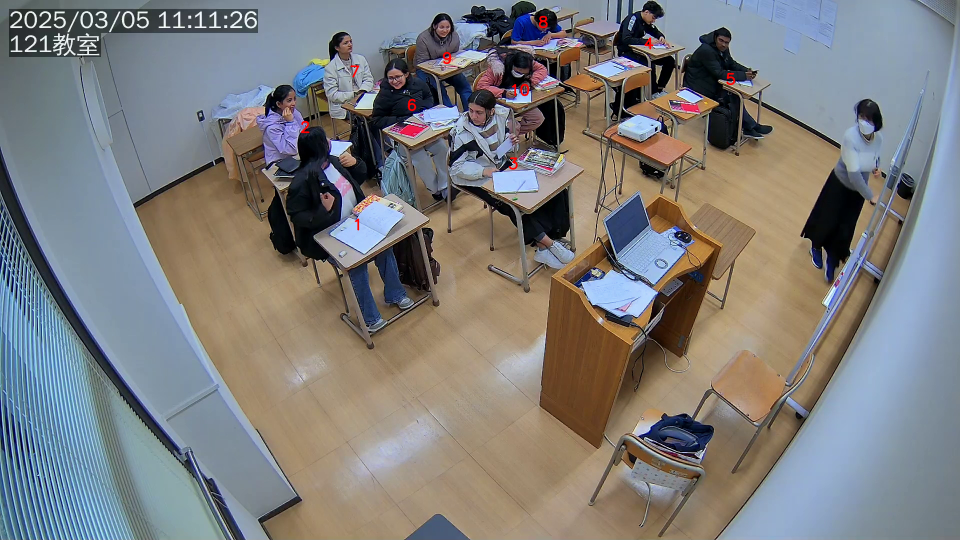

動画の終端に到達したため終了
csvの保存が完了しました。


In [138]:
calc_concenterate_map_from_video_with_mahalanobis(settings, ideal_pose_list, threshold_dist=100)

In [110]:
ideal_pose_list[1].pose_name

'writing_note'